In [1]:
from discord.ext import commands
import discord
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from datetime import datetime
from io import BytesIO
from flask import Flask, request
from threading import Thread
import json, os, sys, re
import pandas as pd
from thongke import generate_chart_pay_by_month, generate_chart_debt

scope = [
    "https://spreadsheets.google.com/feeds",
    "https://www.googleapis.com/auth/drive"
]


# sử dụng local
creds = ServiceAccountCredentials.from_json_keyfile_name(
    "credentials.json", scope)
client_gs = gspread.authorize(creds)
sheet = client_gs.open("chi_tieu_on_dinh").worksheet('log')

data = sheet.get_all_values()



,NGÀY,HẠNG MỤC CHI,TIỀN,NGƯỜI CHI,NGƯỜI NHẬN,GHI CHÚ
0,2025-05-01 00:00:00,cơm tối,90000.0,Nghĩa,Phương Ngân,
1,2025-05-02 00:00:00,cơm tối,84000.0,Nghĩa,Mọi Người,
2,2025-05-03 00:00:00,cơm tối,20000.0,Nghĩa,Nhi,
3,2025-05-04 00:00:00,cơm tối,30000.0,Nghĩa,Đạt,
4,2025-05-05 00:00:00,nước suối,1410000.0,Phương,Mọi Người,
5,2025-05-06 00:00:00,phở,70000.0,Nhi,Phương Nghĩa,
6,2025-05-07 00:00:00,trà sữa,39000.0,Nhi,Ngân,
7,2025-05-08 00:00:00,cơm gà,30000.0,Nhi,Phương,
8,2025-05-09 00:00:00,chìa khoá,100000.0,Nhi,Mọi Người,
9,2025-05-10 00:00:00,trà tranh,50000.0,Nhi,Nghĩa Phương,


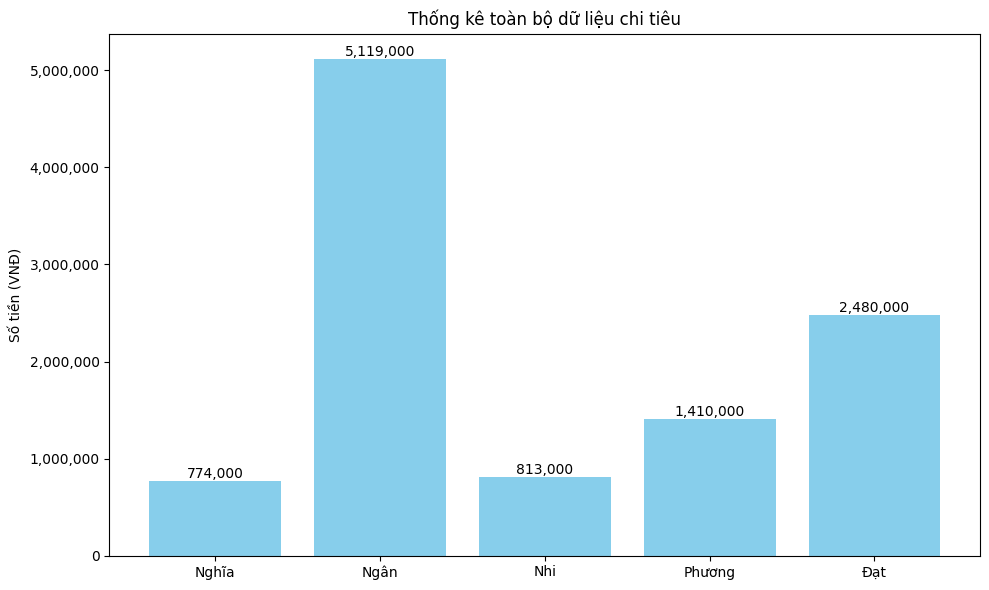

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

df = pd.DataFrame(data[1:], columns=data[0])

# Làm sạch dữ liệu
df['NGÀY'] = pd.to_datetime(df['NGÀY'], errors='coerce', dayfirst=True)
df['TIỀN'] = df['TIỀN'].str.replace(r'[₫\s]', '',
                                    regex=True).str.replace(',',
                                                            '',
                                                            regex=False)
df['TIỀN'] = pd.to_numeric(df['TIỀN'], errors='coerce')
display(df)
df = df.dropna(subset=['NGÀY'])
time = None
if time:
    try:
        month, year = map(int, time.split('/'))
        if month < 1 or month > 12:
            print("Tháng không hợp lệ. Vui lòng nhập tháng từ 1 đến 12.")
            # return False
        df_filtered = df[(df['NGÀY'].dt.month == month)
                            & (df['NGÀY'].dt.year == year)]
    except Exception as e:
        print(f"Lỗi định dạng thời gian: {e}")
        # return False
else:

    df_filtered = df

# Thống kê
result = df_filtered.groupby('NGƯỜI CHI')['TIỀN'].sum().to_dict()
if not result:
    # return False
    pass

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
bars = plt.bar(result.keys(), result.values(), color='skyblue')

plt.xlabel('')
plt.ylabel('Số tiền (VNĐ)')
try:
    plt.title(f"Thống kê chi tiêu tháng {month}/{year}")
except:
    plt.title("Thống kê toàn bộ dữ liệu chi tiêu")
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{int(x):,}"))

for i, (name, value) in enumerate(result.items()):
    plt.text(i,
                value,
                f"{int(value):,}",
                ha='center',
                va='bottom',
                fontsize=10)

plt.tight_layout()

plt.show()
# buf = BytesIO()
# plt.savefig(buf, format='png')
# buf.seek(0)
# plt.close()

In [3]:
import knowledge
import json
import re

with open("slang_mapping.json", "r", encoding="utf-8") as f:
    slang_mapping = json.load(f)
    slang_mapping = {k.strip().lower(): v for k, v in slang_mapping.items()}


import json
import re

with open("slang_mapping.json", "r", encoding="utf-8") as f:
    slang_mapping = json.load(f)

# Normalize key
slang_mapping = {k.strip().lower(): v for k, v in slang_mapping.items()}

def parse_amount(amount_text, slang_mapping):
    if not amount_text:
        return 0, None

    amt_text = amount_text.lower().replace(",", "").replace(" ", "").strip()
    print(amt_text)
    total_amount = 0

    pattern = r"(\d+(?:\.\d+)?)([a-zA-ZÀ-Ỹà-ỹ]*)"  # thêm support tiếng Việt có dấu
    matches = re.findall(pattern, amt_text)
    print(matches)

    last_unit = None
    for number_part, unit_part in matches:
        try:
            base_amount = float(number_part)
        except:
            base_amount = 0

        unit_part = unit_part.strip().lower()

        if unit_part:
            if unit_part not in slang_mapping:
                return 0, f"❌ Đơn vị `{unit_part}` chưa có trong slang. Vui lòng thêm bằng lệnh `bot ngu: {unit_part} = giá trị`."
            multiplier = slang_mapping[unit_part]
            total_amount += int(base_amount * multiplier)
            last_unit = unit_part
        else:
            if last_unit and last_unit in slang_mapping:
                next_step = slang_mapping[last_unit] / 10
                total_amount += int(base_amount * next_step)
            else:
                total_amount += int(base_amount)

    return total_amount, None

print(parse_amount('2tr2', slang_mapping))

2tr2
[('2', 'tr'), ('2', '')]
(2200000, None)


In [4]:
def replace_slang(text, mapping):
    for slang, real_name in mapping.items():
        text = text.replace(slang, str(real_name))
    return text

text = 'anh Đạt, nợ cũ, 2tr480k, nghĩa'

content = text.split(",")
content = [c.strip() for c in content]
print(content[0])
a = replace_slang(content[0].lower(), slang_mapping)
print(a)

anh Đạt
Đạt


In [5]:
sheet_slang_mapping = client_gs.open("chi_tieu_on_dinh").worksheet('slang_mapping')
def load_slang_from_sheet(slang_sheet):
    rows = slang_sheet.get_all_records()
    slang_mapping = {}

    for row in rows:
        key = row['slang'].strip().lower()
        type_ = row['type']
        value_raw = row['value']

        if type_ == "number":
            value = float(value_raw)
        elif type_ == "list":
            value = [v.strip() for v in value_raw.split(",")]
        else:
            value = value_raw

        slang_mapping[key] = value

    return slang_mapping

def replace_slang(text, mapping):
    # Sắp xếp slang theo độ dài giảm dần để replace từ dài trước
    sorted_mapping = sorted(mapping.items(), key=lambda x: len(x[0]), reverse=True)
    
    for slang, real_value in sorted_mapping:
        text = text.replace(slang, str(real_value))
    return text


def update_slang_mapping_to_sheet(message_content, sheet_slang_mapping):
    # Regex tách dạng "bot ngu: something = something"
    pattern = r"bot ngu:\s*(.+?)\s*=\s*(.+)"
    match = re.match(pattern, message_content, re.IGNORECASE)

    if match:
        key = match.group(1).strip()
        value_raw = match.group(2).strip()

        # Xác định kiểu dữ liệu của value
        try:
            value = int(value_raw.replace(",", "").replace(".", ""))
            type_ = "number"
        except ValueError:
            # Nếu nhập value là list cách nhau bằng dấu ,
            if "," in value_raw:
                value = [v.strip() for v in value_raw.split(",")]
                type_ = "list"
                value_raw = ",".join(value)  # để lưu lên sheet
            else:
                value = value_raw
                type_ = "string"

        # Kiểm tra xem key đã tồn tại chưa
        rows = sheet_slang_mapping.get_all_records()
        for i, row in enumerate(rows):
            if row['slang'] == key:
                sheet_slang_mapping.update_cell(i+2, 2, type_)
                sheet_slang_mapping.update_cell(i+2, 3, value_raw)
                return f"Đã cập nhật: '{key}' → '{value_raw}'"

        # Nếu chưa có thì thêm mới
        sheet_slang_mapping.append_row([key, type_, value_raw])
        return f"Đã thêm mới: '{key}' → '{value_raw}'"
    else:
        return "Cú pháp sai rồi bro! Dùng đúng dạng: bot ngu: cái này = cái kia"
    


slang_mapping = load_slang_from_sheet(sheet_slang_mapping)
text = 'chị ngân, đi chợ, 100k, Chị Ngân'

print(slang_mapping)
print(replace_slang(text.split(",")[3].lower(), slang_mapping))

{'chị ngân': 'Ngân', 'k': 1000.0, 'tr': 1000000.0, 'tỷ': 1000000000.0, 'mn': 'mọi người', 'harmonious_fox_17849': 'Nghĩa', 'doufang_8': 'Phương', 'anh phương': 'Phương', 'ann_nguyen123': 'Ngân', 'chị nhi': 'Nhi', 'chị dung': 'Dung', 'username': ['Dung', 'Ngân', 'Nhi', 'Đạt', 'Phương', 'Nghĩa'], 'thanhdat153': 'Đạt'}
 Ngân


C:\Users\NguyenHuuNghia\AppData\Local\Temp\ipykernel_1500\2806197932.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["TIỀN"] = df_filtered.apply(chia_tien, axis=1)
C:\Users\NguyenHuuNghia\AppData\Local\Temp\ipykernel_1500\2806197932.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["TIỀN"] = df_filtered.apply(chia_tien, axis=1)
C:\Users\NguyenHuuNghia\AppData\Local\Temp\ipykernel_1500\2806197932.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

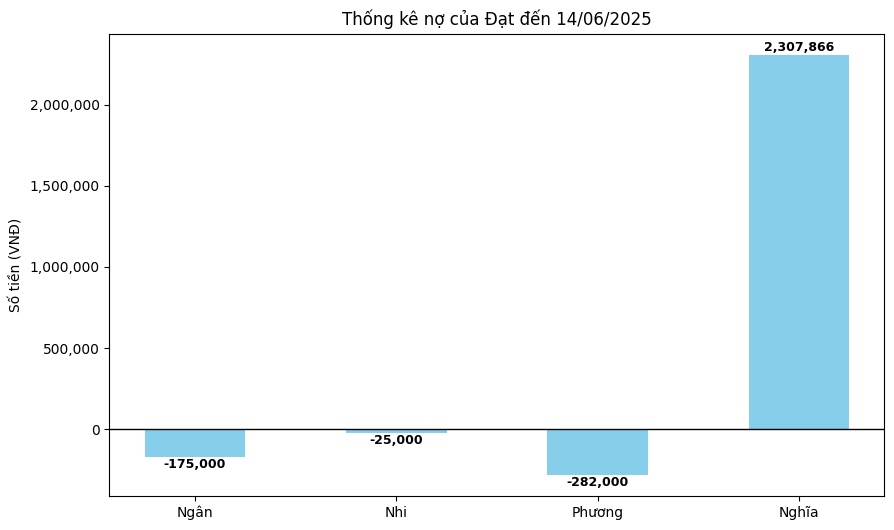

In [9]:
import pytz
timezone = pytz.timezone("Asia/Ho_Chi_Minh")

def load_data(data):
        df = pd.DataFrame(data[1:], columns=data[0])
        df.columns = [col.strip() for col in df.columns]

        # Ép kiểu ngày
        df['NGÀY'] = pd.to_datetime(df['NGÀY'], errors='coerce', dayfirst=True)

        # Làm sạch cột TIỀN:
        df['TIỀN'] = df['TIỀN'].str.replace(r'[₫\s]', '', regex=True)  # bỏ ₫ và khoảng trắng
        df['TIỀN'] = df['TIỀN'].str.replace(',', '', regex=False)      # bỏ dấu phẩy hàng nghìn

        # Giữ dấu chấm thập phân, sau đó ép kiểu float
        df['TIỀN'] = pd.to_numeric(df['TIỀN'], errors='coerce')

        data = df.dropna(subset=['NGÀY'])
        # print(self.df[['NGÀY', 'NGƯỜI CHI', 'TIỀN']])
        # print(f"✅ Đã tải {len(self.df)} dòng dữ liệu (sau khi xử lý ngày và tiền)")
        return data

# thống kê nợ từng người
def total_debt_by_person_in_month(data, month=None, year=None):
        data = load_data(data)
        pd.set_option('display.float_format', '{:,.0f}'.format)
        payer = data['NGƯỜI CHI'].unique().tolist()
        
        
        # data['NGƯỜI NHẬN'] = data['NGƯỜI NHẬN']
        all_names = []

        known_names = ['Mọi Người']

        for recipients in data['NGƯỜI NHẬN']:
            if recipients in known_names:
                all_names.append(recipients)
            else:
                # Những trường hợp còn lại (như 'Mọi Người', 'Nhi', 'Nghĩa') để nguyên từng cái
                all_names.extend(recipients.split(' '))  # giả sử mỗi tên cách nhau bằng dấu ' '

        unique_names = list(set(payer+all_names))  # Loại bỏ trùng lặp
        # print(unique_names)
        debt_by_person = {}
        done_pairs = set()
        total_pay_by_p = total_pay_by_r = 0
        def chia_tien(row):
            recipients = row["NGƯỜI NHẬN"]
            amount = row["TIỀN"]

            if recipients == "Mọi Người":
                return amount / 5
            else:
                num_recipients = len(recipients.split(" "))
                return amount / num_recipients if num_recipients > 0 else amount

        for p in unique_names: # p là payer
            for r in unique_names: # r là receiver
                if p != r and (p, r) not in done_pairs and (r, p) not in done_pairs:
                    df_filtered = data[
                    (
                        ((data['NGƯỜI CHI'] == p) & (data['NGƯỜI NHẬN'] == r)) |
                        ((data['NGƯỜI CHI'] == r) & (data['NGƯỜI NHẬN'] == p)) |
                        ((data['NGƯỜI CHI'] == p) & (data['NGƯỜI NHẬN'] == 'Mọi Người')) |
                        ((data['NGƯỜI CHI'] == r) & (data['NGƯỜI NHẬN'] == 'Mọi Người')) |
                        (
                            (data['NGƯỜI CHI'] == p) &
                            (data['NGƯỜI NHẬN'].str.contains(r, na=False))
                        ) |
                        (
                            (data['NGƯỜI CHI'] == r) &
                            (data['NGƯỜI NHẬN'].str.contains(p, na=False))
                        )
                    )]
                    
                    # df_filtered.loc[df_filtered["NGƯỜI NHẬN"] == "Mọi Người", "TIỀN"] /= 5  # Giả sử có 5 người chi tiêu chung, chia đều tiền cho mỗi người
                    if df_filtered.empty:
                        continue
                    df_filtered["TIỀN"] = df_filtered.apply(chia_tien, axis=1)
                    total_pay_by_p = df_filtered[df_filtered['NGƯỜI CHI'] == p]['TIỀN'].sum()
                    total_pay_by_r = df_filtered[df_filtered['NGƯỜI CHI'] == r]['TIỀN'].sum()
                    debt = total_pay_by_p-total_pay_by_r
                    if debt > 0:
                        debt_by_person[(p, r)] = debt
                    elif debt < 0:
                        debt_by_person[(r, p)] = -debt

                done_pairs.add((p, r))  # Loại bỏ người đã tính để tránh tính lại
        df = pd.DataFrame([(p[0], p[1], r) for p,r in debt_by_person.items() if p[1] != 'Mọi Người'], columns=['Chủ nợ', 'Người nợ', 'Số tiền'])
        df_group_detail = df.groupby(['Người nợ', 'Chủ nợ'])['Số tiền'].sum().reset_index().sort_values(by='Người nợ')
        return df_group_detail

def generate_chart_debt(name, data):
    df_debt = total_debt_by_person_in_month(data)
    
    df_person_r = df_debt[df_debt['Người nợ'] == name][['Chủ nợ', 'Số tiền']].copy()
    df_person_r.rename(columns={'Chủ nợ': 'Tên người'}, inplace=True)
    df_person_r['Giá trị'] = -df_person_r['Số tiền']

    df_person_p = df_debt[df_debt['Chủ nợ'] == name][['Người nợ', 'Số tiền']].copy()
    df_person_p.rename(columns={'Người nợ': 'Tên người'}, inplace=True)
    df_person_p['Giá trị'] = df_person_p['Số tiền']

    df_all = pd.concat([df_person_r[['Tên người', 'Giá trị']], df_person_p[['Tên người', 'Giá trị']]])

    if df_all.empty:
        print(f"{name} không có khoản nợ nào.")
        return

    plt.figure(figsize=(10, 6))
    
    # Tên người và giá trị
    names = df_all['Tên người'].tolist()
    values = df_all['Giá trị'].tolist()


    # Vẽ biểu đồ
    bars = plt.bar(names, values, color='skyblue', width=0.5)

    plt.axhline(0, color='black', linewidth=1)

    # Format trục y
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

    plt.title(f'Thống kê nợ của {name} đến {datetime.now(timezone).strftime("%d/%m/%Y")}')
    plt.ylabel('Số tiền (VNĐ)')
    plt.xlabel('')

    # Thêm số tiền lên đầu cột
    for bar in bars:
        height = bar.get_height()
        if height != 0:
            offset = 5_000 if height > 0 else -5_000
            va = 'bottom' if height > 0 else 'top'
            plt.text(bar.get_x() + bar.get_width()/2, height + offset,
                     f'{int(height):,}', ha='center', va=va,
                     fontsize=9, color='black', fontweight='bold')

    # buf = BytesIO()
    # plt.savefig(buf, format='png')
    # buf.seek(0)
    # plt.close()

    # return buf
    plt.show()


chart_debt = generate_chart_debt(name, data)

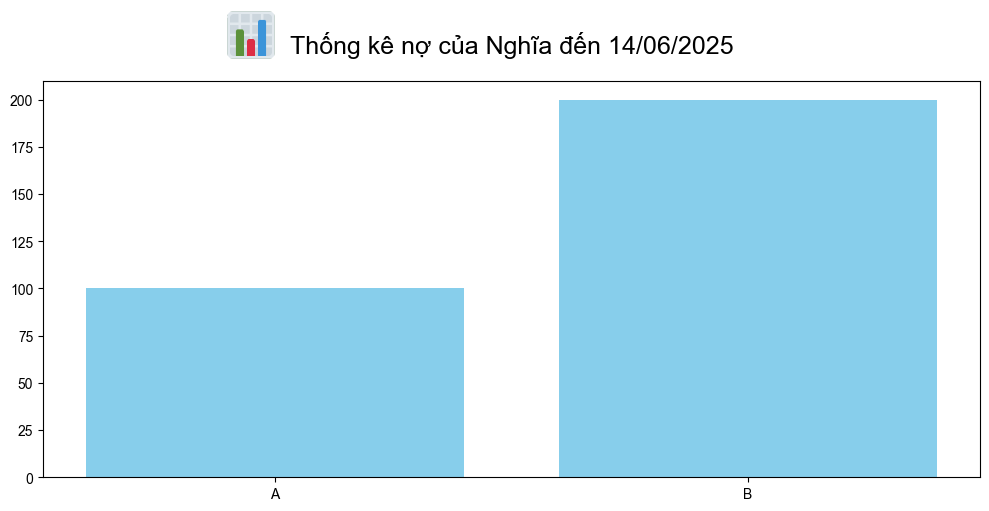

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Dữ liệu mẫu
names = ['A', 'B']
values = [100, 200]

# Tạo figure và axes
fig, ax = plt.subplots(figsize=(10, 5))

# Vẽ bar chart
ax.bar(names, values, color='skyblue')

# Đặt tiêu đề chart
title_text = f"Thống kê nợ của Nghĩa đến 14/06/2025"
title = plt.title(title_text, fontsize=18, color='black', pad=20)

# Lấy vị trí title để canh icon
renderer = fig.canvas.get_renderer()
title_bbox = title.get_window_extent(renderer=renderer)

# Load icon PNG
icon = mpimg.imread('asset/bar-chart.png')
imagebox = OffsetImage(icon, zoom=0.5)

# Chuyển từ pixel sang figure fraction
icon_x = (title_bbox.x0 - 40) / fig.bbox.width
icon_y = (title_bbox.y0 + title_bbox.height/2) / fig.bbox.height

# Đặt vị trí icon canh theo title
ab = AnnotationBbox(imagebox, (icon_x, icon_y), xycoords='figure fraction', frameon=False)
fig.add_artist(ab)

# Căn chỉnh layout
plt.tight_layout()
plt.show()


